# Feature Engineering / Modeling

This notebook contains info on feature engineering and modeling

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

%matplotlib inline

In [27]:
employee_survey_data = pd.read_csv("../data/hr/employee_survey_data.csv")
general_data = pd.read_csv("../data/hr/general_data.csv")
manager_survey_data = pd.read_csv("../data/hr/manager_survey_data.csv")

In [28]:
employee_survey_data = employee_survey_data.set_index("EmployeeID")
general_data = general_data.set_index("EmployeeID")
manager_survey_data = manager_survey_data.set_index("EmployeeID")

In [29]:
# make a full df which merges on the index
full_df = pd.concat([employee_survey_data, general_data, manager_survey_data], axis="columns")

In [30]:
full_df = full_df.dropna(how="any")

In [31]:
full_df.shape

(4300, 28)

In [32]:
df = full_df.copy()

In [33]:
df["Attrition"] = df["Attrition"].apply(lambda x: 0 if x == "No" else 1)

### Interactions

In [34]:
# create a feature called PortionLifeWorking, which is the ratio of years working to age
df["PortionLifeWorking"] = df["TotalWorkingYears"] / df["Age"]

In [35]:
# change gender to binary, in terms of Male. Male = 1, Female = 0
df["Male"] = df["Gender"].apply(lambda x: 0 if x == "Female" else 1)
df = df.drop(columns=["Gender"])

In [36]:
# drop Over18 because it's constant (everyone is over 18)
df = df.drop(columns=["Over18"])

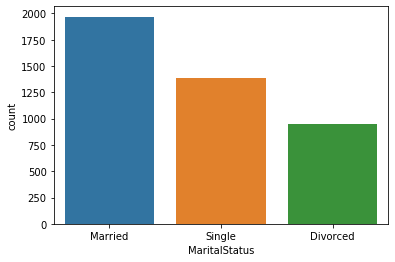

In [37]:
sns.countplot(df.MaritalStatus)

In [38]:
# encode the rest of our variables
# we need to select all of the categorical variables to do this
dummify = [
    "Department",
    "EducationField",
    "JobRole",
    "MaritalStatus",
]

for dummy in dummify:
    df = pd.concat([df, pd.get_dummies(df[dummy], drop_first=True)], axis="columns")

df = df.drop(columns=dummify)

In [39]:
# encode ordinal categorical variables
# in this case BuisnessTravel
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df["BusinessTravel"] = label_encoder.fit_transform(df["BusinessTravel"])

In [40]:
df.shape

(4300, 41)

In [41]:
# take the numerical values and plot the heatmap
refined_columns_of_interest = [
    "Age",
    "JobLevel",
    "MonthlyIncome",
    "NumCompaniesWorked",
    "TotalWorkingYears",
    "YearsAtCompany",
    "Education",
    "StockOptionLevel",
    "TrainingTimesLastYear",
    "YearsSinceLastPromotion",
    "YearsWithCurrManager",
    "PerformanceRating", # manager based stuff
    "JobInvolvement",
    "Attrition",
    "BusinessTravel",
    "PortionLifeWorking"
]

refined_df = df[refined_columns_of_interest]

Text(0.5, 1, 'Numerical Feature Correlation Heatmap')

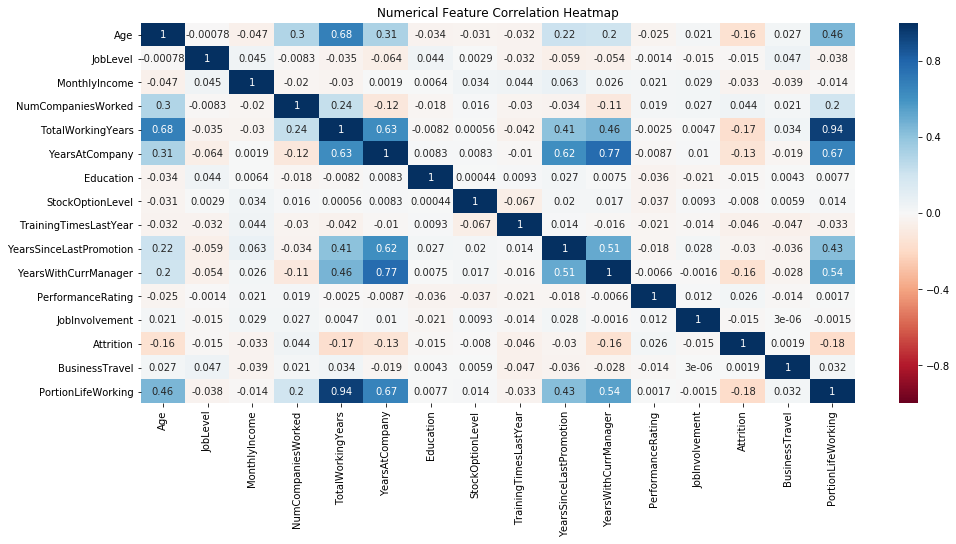

In [42]:
# define a figure to plot on
plt.figure(figsize=(16, 7))
sns.heatmap(refined_df.corr(), annot=True, vmax=1, vmin=-1, cmap=sns.color_palette("RdBu", 1000)).set_title("Numerical Feature Correlation Heatmap")

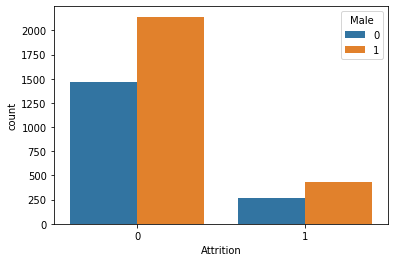

In [43]:
# gender attrition breakdown
sns.countplot(x="Attrition", data=df, hue="Male")

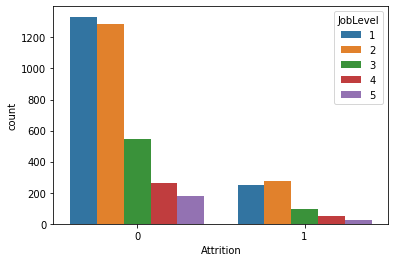

In [44]:
# attrition at each job level
sns.countplot(x="Attrition", data=df, hue="JobLevel")

## Modeling

Text(0.5, 1.0, 'Distribution of Attrition values')

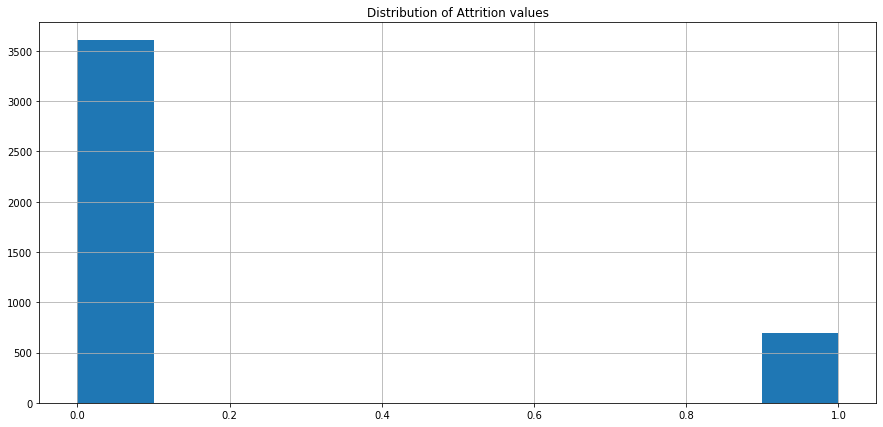

In [45]:
# let's look at our target outcome breakdown
df.Attrition.hist(figsize=(15,7)).set_title("Distribution of Attrition values")

In [46]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=23)

In [47]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from inspect import signature

def create_auprc_curve(y_test, y_score, title_prefix="model"):
    average_precision = average_precision_score(y_test, y_score)
    
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
#     plt.figure(figsize=(15, 10))
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve for {}: AP={}'.format(
            title_prefix,
            round(average_precision, 2)))
    plt.show()

In [48]:
def create_roc_curve(y_test, y_score, title_prefix="model"):
    
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_score)
    
    # find the area under the roc curve
    auc_score = auc(false_positive_rate, true_positive_rate)
    
    # now plot the curve
#     plt.figure(figsize=(15, 10))
    lw = 2
    plt.plot(false_positive_rate, true_positive_rate, color='darkred',
             lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('2-Class ROC for {}'.format(title_prefix))
    plt.legend(loc="lower right")
    plt.show()

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [50]:
# create some grid searching tools for Logistic Regression, Gradient Boosting, Random Forrest, and Support Vector Classifier

# logistic regression parameters
lr_params = {"C": [0.1, 1.0, 10., 100.], "penalty": ["l1", "l2"], "solver": ["liblinear"]}

# gradient boosting possible parameters
gb_params = {"loss": ["deviance", "exponential"], "n_estimators": [5, 10, 50, 100, 1000], "subsample": [0.1, 0.3, 0.6, 0.9, 1]}

# support vector classifier parameters
svc_params = grid_parameters = {'C': [1], 'gamma': ["scale", "auto"], 'kernel': ['rbf']}


In [51]:
models_dict_main = {
    LogisticRegression: lr_params,
    GradientBoostingClassifier: gb_params,
    SVC: svc_params
}

In [52]:
def evaluate_models(models, X_train, X_test, y_train, y_test):
    """Performs classification using the provided `models` and the data provided.
    
    Plots AUPRC & AUCROC curves with scores for each model
    
    Parameters
    ----------
    
    models : dict
        A key-value pair of models, where the key is the name of the classifier,
        and the value is the model instance
    ...
    
    
    """
    
    for model, parameters in models.items():
        model_name = str(model.__name__)
        print("Training Model: {}".format(model_name))
        # first train the model on the train set
        grid_model = GridSearchCV(model(), parameters, refit=True, verbose=0, n_jobs=8)
        grid_model.fit(X_train, y_train)
        
        # get decision function
        y_score = grid_model.decision_function(X_test)
        y_pred = grid_model.predict(X_test)
        
        create_auprc_curve(y_test, y_score, title_prefix=model_name)
        
        create_roc_curve(y_test, y_score, title_prefix=model_name)
        
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="RdBu", fmt="d")
        plt.show()
        
        
        # compute the raw train & test score for the classifier
        # print the score, and the best parameters
        print("Best Score: {}".format(grid_model.best_score_))
        print("Train Score: {}".format(grid_model.score(X_train, y_train)))
        print("Test Score: {}".format(grid_model.score(X_test, y_test)))
        print("Best Params: {}".format(grid_model.best_params_))
        print("")
#         train_score = model.score(X_train, y_train)
#         print("Train score for {}: {}".format(name, train_score))
        
#         test_score = model.score(X_test, y_test)
#         print("Test score for {}: {}".format(name, test_score))
        
#         # compute the mean cv score
        cross_validation_score = cross_val_score(grid_model, X_test, y_test, cv=20, n_jobs=8)
        print("Mean Test Cross Val score (k=20) for {}: {}".format(model_name, cross_validation_score.mean()))
    
#         if hasattr(model, "_gamma"):
#             print("Gamma: {}".format(model._gamma))
    

Training Model: LogisticRegression


/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


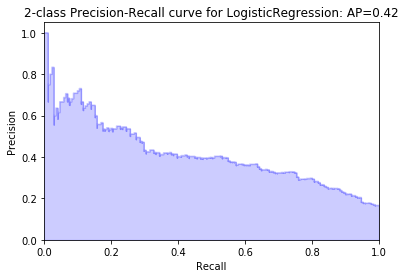

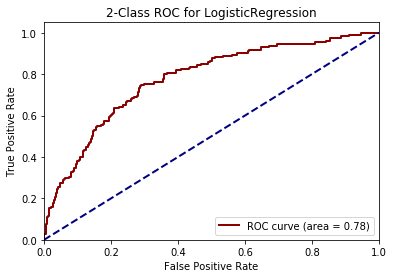

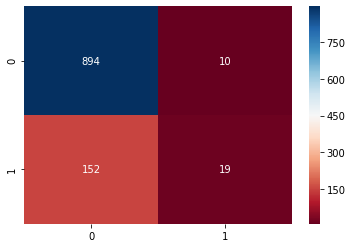

Best Score: 0.8480620155038759
Train Score: 0.8502325581395349
Test Score: 0.8493023255813954
Best Params: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

Mean Test Cross Val score (k=20) for LogisticRegression: 0.8384235436122228
Training Model: GradientBoostingClassifier


/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


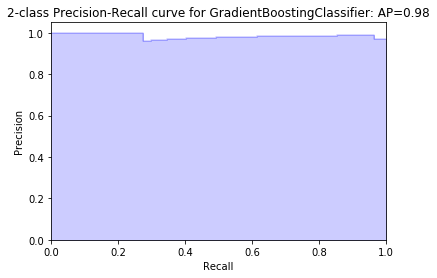

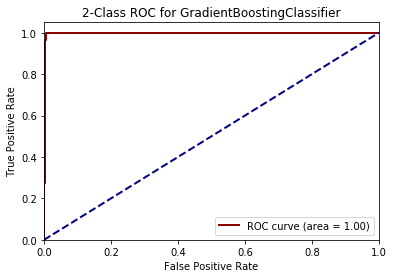

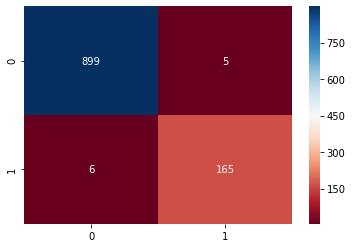

Best Score: 0.9665116279069768
Train Score: 1.0
Test Score: 0.9897674418604652
Best Params: {'loss': 'deviance', 'n_estimators': 1000, 'subsample': 1}

Mean Test Cross Val score (k=20) for GradientBoostingClassifier: 0.8846277237786673
Training Model: SVC


/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


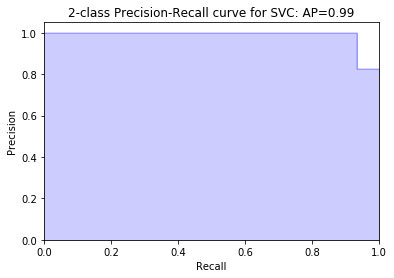

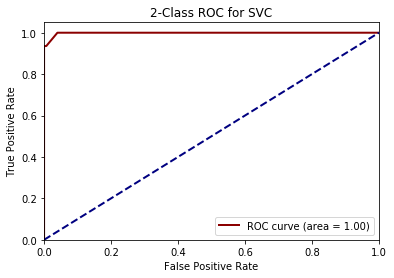

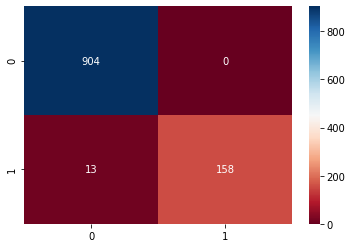

Best Score: 0.9624806201550388
Train Score: 0.9996899224806202
Test Score: 0.987906976744186
Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Mean Test Cross Val score (k=20) for SVC: 0.9023607140588272


In [53]:
evaluate_models(models_dict_main, X_train, X_test, y_train, y_test)

--------------
N Components: 4
Training Model: LogisticRegression


/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


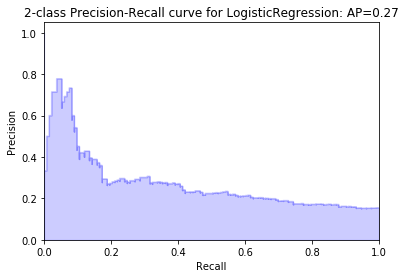

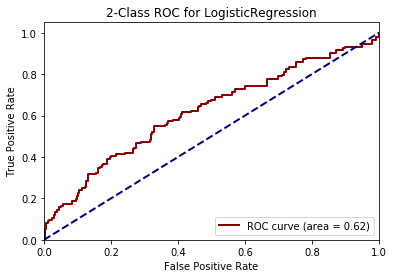

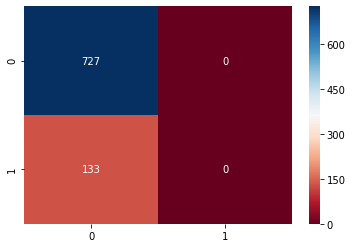

Best Score: 0.8366279069767442
Train Score: 0.8366279069767442
Test Score: 0.8453488372093023
Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Mean Test Cross Val score (k=20) for LogisticRegression: 0.8454809725158563
Training Model: GradientBoostingClassifier


/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


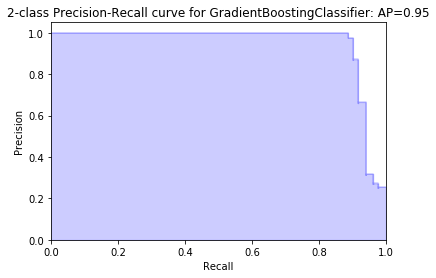

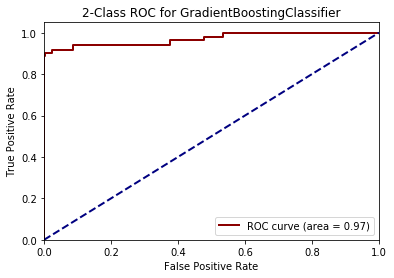

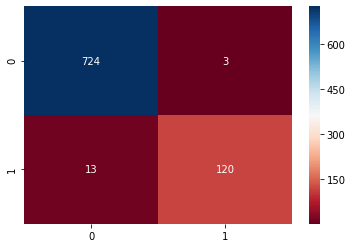

Best Score: 0.9555232558139535
Train Score: 1.0
Test Score: 0.9813953488372092
Best Params: {'loss': 'deviance', 'n_estimators': 1000, 'subsample': 0.9}

Mean Test Cross Val score (k=20) for GradientBoostingClassifier: 0.8952833987717707
Training Model: SVC


/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


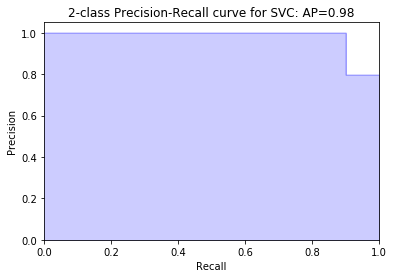

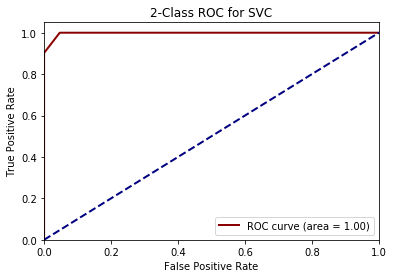

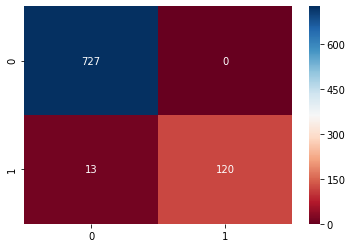

Best Score: 0.961046511627907
Train Score: 1.0
Test Score: 0.9848837209302326
Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Mean Test Cross Val score (k=20) for SVC: 0.9118959528843249
--------------
N Components: 3
Training Model: LogisticRegression


/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


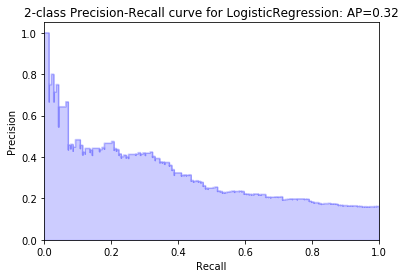

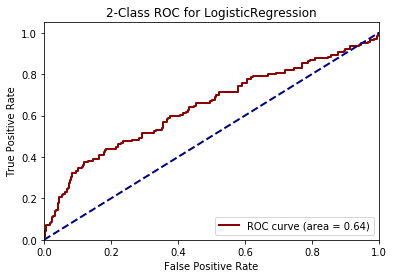

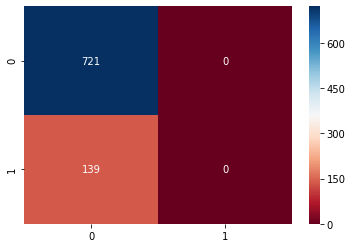

Best Score: 0.8383720930232558
Train Score: 0.8383720930232558
Test Score: 0.8383720930232558
Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Mean Test Cross Val score (k=20) for LogisticRegression: 0.8383909694956205
Training Model: GradientBoostingClassifier


/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


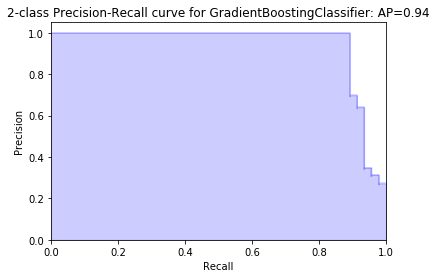

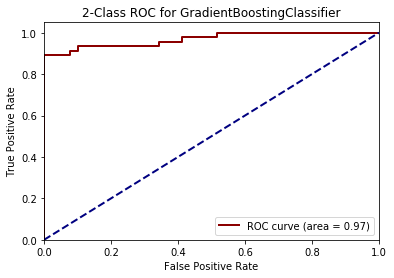

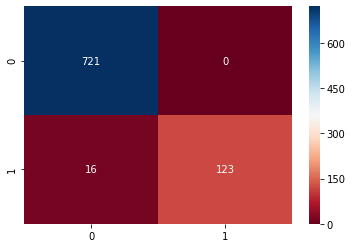

Best Score: 0.9578488372093024
Train Score: 0.9997093023255814
Test Score: 0.9813953488372092
Best Params: {'loss': 'deviance', 'n_estimators': 1000, 'subsample': 0.9}

Mean Test Cross Val score (k=20) for GradientBoostingClassifier: 0.8616782442363837
Training Model: SVC


/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


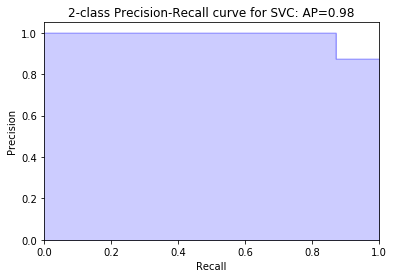

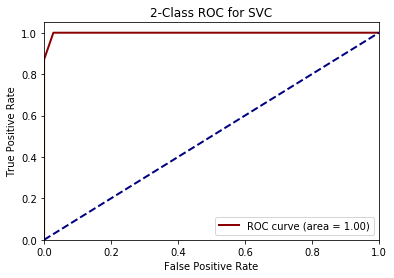

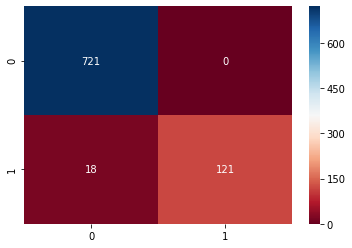

Best Score: 0.9598837209302326
Train Score: 1.0
Test Score: 0.9790697674418605
Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Mean Test Cross Val score (k=20) for SVC: 0.8965355381053056
--------------
N Components: 2
Training Model: LogisticRegression


/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


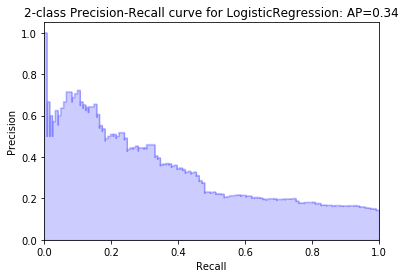

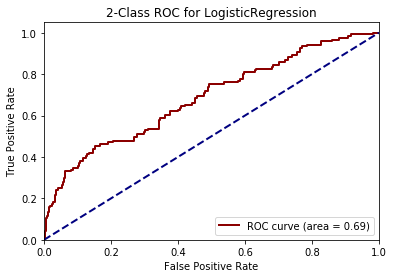

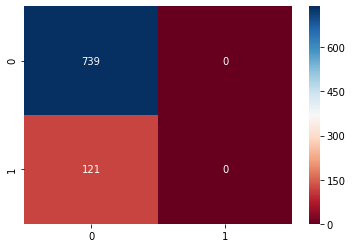

Best Score: 0.833139534883721
Train Score: 0.833139534883721
Test Score: 0.8593023255813953
Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Mean Test Cross Val score (k=20) for LogisticRegression: 0.8593212020537602
Training Model: GradientBoostingClassifier


/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


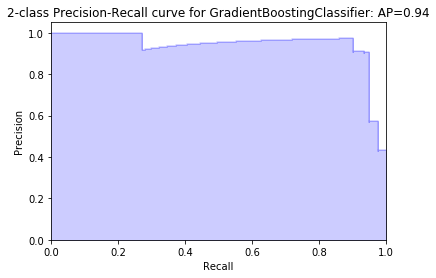

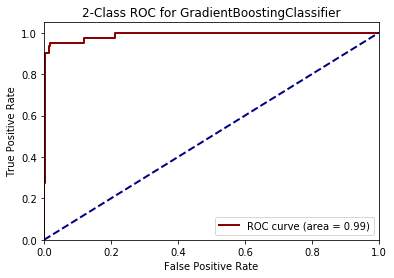

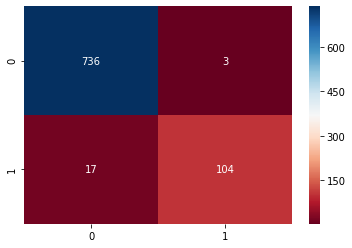

Best Score: 0.9462209302325582
Train Score: 0.9982558139534884
Test Score: 0.9767441860465116
Best Params: {'loss': 'deviance', 'n_estimators': 1000, 'subsample': 0.9}

Mean Test Cross Val score (k=20) for GradientBoostingClassifier: 0.8627818886539815
Training Model: SVC


/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


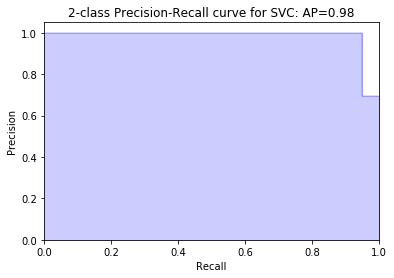

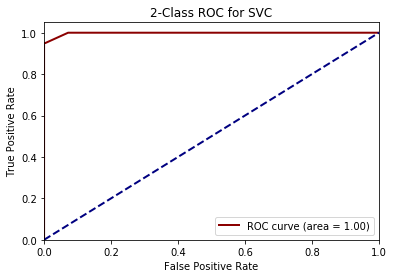

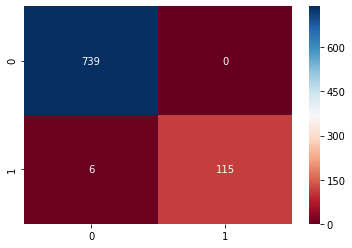

Best Score: 0.951453488372093
Train Score: 1.0
Test Score: 0.9930232558139535
Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Mean Test Cross Val score (k=20) for SVC: 0.9034820799355684


In [57]:
for n_components in (4, 3, 2):
    pca = PCA(n_components=n_components)
    
    print("--------------")
    print("N Components: {}".format(n_components))
    features_downsampled = pca.fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(features_downsampled, target, test_size=0.2)
    
    # fit the same models as before
    evaluate_models(models_dict_main, X_train, X_test, y_train, y_test)